In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device=torch.device('cpu')

# Domik Dataset

In [3]:
class DomikDataset(Dataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__()
        self.house_width = 0.6
        self.house_height = 0.7
        self.roof_height = 0.3
        
        self.points, self.targets = self._generate(dataset_size, noise)

    def _left_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 - self.house_width) / 2) / \
            (0.5 - (1 - self.house_width) / 2)
        k =  2 * (self.house_height - b) / (1 - self.house_width)
        return k * point[0] + b >= point[1]

    def _right_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 + self.house_width) / 2) / \
            (0.5 - (1 + self.house_width) / 2)
        k = 2 * (self.house_height - b) / (1 + self.house_width)
        return k * point[0] + b >= point[1]
    
    
    def _generate(self, size, noise):
        points = [[random.random(), random.random()] for i in range(size)]

        targets = []
        for point in points:
            if (1 - self.house_width) / 2 <= point[0] <= (1 + self.house_width) / 2 and \
                self._left_roof(point) and self._right_roof(point):   
                inside = 1.
            else:
                inside = 0.

            if random.random() < noise:
                inside = 1. - inside

            targets.append(torch.tensor([inside], device=device))

        return points, targets
    
    def show(self, dividing_criterion=lambda s: 1 if s > 0.5 else 0):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []

        for sample in self:
            point, target = sample
            if dividing_criterion(target):
                domik_x.append(point[0])
                domik_y.append(point[1])
            else: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.')

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
               
        sample = (torch.tensor(self.points[idx], device=device), self.targets[idx])

        return sample

# Train function

In [4]:
def train(network, train_dataset, epochs, criterion, optimizer):
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for sample in train_dataset:
            optimizer.zero_grad()   # zero the gradient buffers
            point, target = sample
            output = network(point)
            loss = criterion(output, target.to(device))
            loss.backward()
            loss_samples.append(loss.data.numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

# Test function

In [5]:
def test(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

# First steps

## Dataset

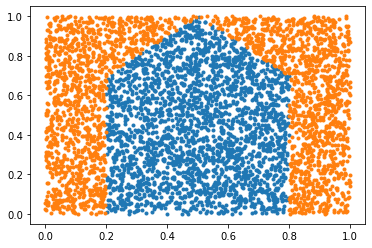

In [25]:
DATASET_SIZE = 5000
domik = DomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=1)

# plotting
domik.show()

## Net

In [8]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=1, bias=True)
)


In [7]:
? nn.Linear

In [117]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)


## Train

Epoch        0 Loss: 0.1052110839485008
Epoch        1 Loss: 0.058639855245306446
Epoch        2 Loss: 0.04850039592691507
Epoch        3 Loss: 0.04423031154669936
Epoch        4 Loss: 0.04113556874730017
Epoch        5 Loss: 0.038703096035386
Epoch        6 Loss: 0.03644983461653108
Epoch        7 Loss: 0.03446090786864501
Epoch        8 Loss: 0.03277238864881795
Epoch        9 Loss: 0.031556802570474884
Epoch       10 Loss: 0.030363195670293466
Epoch       11 Loss: 0.029520612842032484
Epoch       12 Loss: 0.02805436410037107
Epoch       13 Loss: 0.027437114378018778
Epoch       14 Loss: 0.026782912989456856
Epoch       15 Loss: 0.02628700845374819
Epoch       16 Loss: 0.025565520466131378
Epoch       17 Loss: 0.0247240715407554
Epoch       18 Loss: 0.02426511089910225
Epoch       19 Loss: 0.02406968410301834
Epoch       20 Loss: 0.02377572976835765
Epoch       21 Loss: 0.023355214536951472
Epoch       22 Loss: 0.02293237754138025
Epoch       23 Loss: 0.02245590678622637
Epoch       

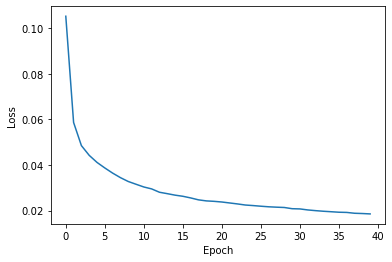

In [118]:
EPOCHS_TO_TRAIN = 40
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), #BCELoss, CrossEntropyLoss MSELoss
      optimizer=optim.SGD(net.parameters(), lr=0.05))

In [66]:
? train

## Test

Accuracy of the network on the 25000 test samples: 98.096


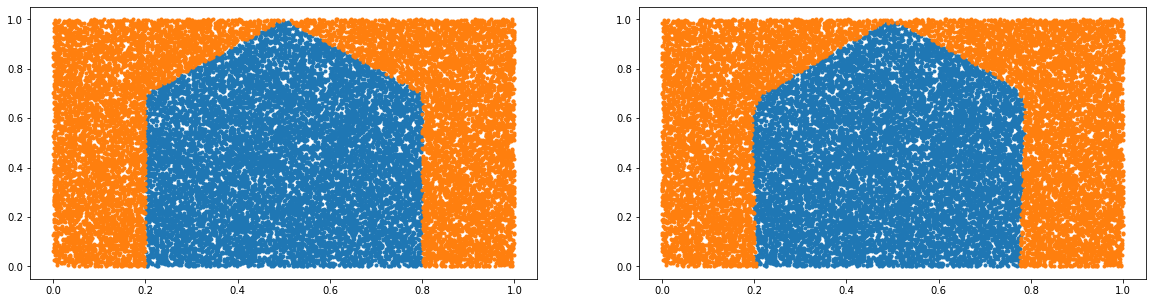

In [119]:
test_dataset = DomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik dataset for multi classes

In [120]:
class MultiClassDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def show(self, dividing_criterion=lambda s: s[0] > s[1]):
        #super().show(dividing_criterion)
        super().show()
        
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, target in enumerate(targets):
            targets[i] = int(targets[i].item())
        return points, targets

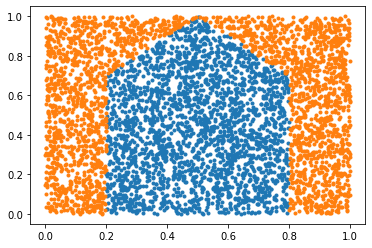

In [121]:
DATASET_SIZE = 5000
domik = MultiClassDomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=3)

# plotting
domik.show()

## Net

In [152]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)


## Train

Let's split learning process into 2 parts: with high and lower learning rate

Epoch        0 Loss: 0.692060619467522
Epoch        1 Loss: 0.6225803462541525
Epoch        2 Loss: 0.5791209040776154
Epoch        3 Loss: 0.5241528158559368
Epoch        4 Loss: 0.34464351649353664
Epoch        5 Loss: 0.24635818647150895
Epoch        6 Loss: 0.14251618831791096
Epoch        7 Loss: 0.12004965503539534
Epoch        8 Loss: 0.11049902152504716
Epoch        9 Loss: 0.10242390691140893
Epoch       10 Loss: 0.09525349787291741
Epoch       11 Loss: 0.09107608451704567
Epoch       12 Loss: 0.08765520547631984
Epoch       13 Loss: 0.0844619449376621
Epoch       14 Loss: 0.08178666197742068
Epoch       15 Loss: 0.07941109044359355
Epoch       16 Loss: 0.07766498115835178
Epoch       17 Loss: 0.07565444966466953
Epoch       18 Loss: 0.0738542337625621
Epoch       19 Loss: 0.07213202924748213


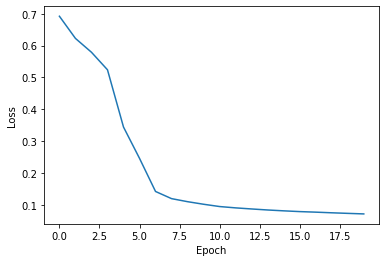

In [153]:
# learning first epochs with high rate 
EPOCHS_TO_TRAIN = 20
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

Epoch        0 Loss: 0.0392389466967731
Epoch        1 Loss: 0.037642939549110285
Epoch        2 Loss: 0.03725814378571802
Epoch        3 Loss: 0.036979993088567996
Epoch        4 Loss: 0.03677557279716576
Epoch        5 Loss: 0.03651698973510574
Epoch        6 Loss: 0.03629284613406334
Epoch        7 Loss: 0.03606292670465032
Epoch        8 Loss: 0.035867831817939066
Epoch        9 Loss: 0.035672231010067716
Epoch       10 Loss: 0.03547446791608833
Epoch       11 Loss: 0.0352912167845208
Epoch       12 Loss: 0.0351255588927495
Epoch       13 Loss: 0.03496771208448179
Epoch       14 Loss: 0.03480533900352298
Epoch       15 Loss: 0.03463877088430921
Epoch       16 Loss: 0.03450120656884545
Epoch       17 Loss: 0.034336599112402055
Epoch       18 Loss: 0.03419572660793598
Epoch       19 Loss: 0.03404116523730081
Epoch       20 Loss: 0.03388744037608841
Epoch       21 Loss: 0.03374690819422879
Epoch       22 Loss: 0.03361303594804134
Epoch       23 Loss: 0.03348327020848338
Epoch       24

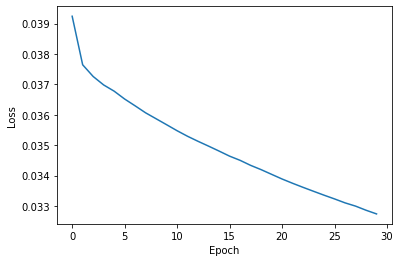

In [154]:
# then learning with low rate 
EPOCHS_TO_TRAIN = 30
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

## Test

In [125]:
def test_multiple(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

Accuracy of the network on the 25000 test samples: 99.612


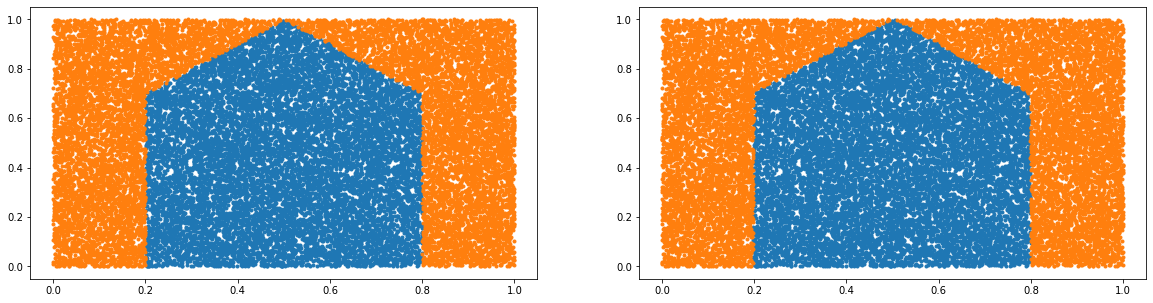

In [155]:
test_dataset = MultiClassDomikDataset(DATASET_SIZE*5)
test_multiple(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik with window dataset

In [156]:
class WindowedDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _window(self, point, width=0.3, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point):
                targets[i] = torch.tensor([0.], device=device)
        return points, targets

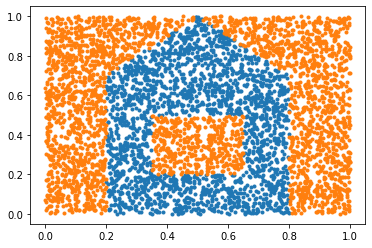

In [157]:
DATASET_SIZE = 5000
domik = WindowedDomikDataset(DATASET_SIZE)

# plotting
domik.show()

## Net

In [165]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)


## Train

Epoch        0 Loss: 0.21753295670588532
Epoch        1 Loss: 0.16563448001611694
Epoch        2 Loss: 0.14860744669403675
Epoch        3 Loss: 0.13544310099863854
Epoch        4 Loss: 0.12270355936771507
Epoch        5 Loss: 0.11769362165282332
Epoch        6 Loss: 0.09529899509760076
Epoch        7 Loss: 0.0859401153642098
Epoch        8 Loss: 0.08635776792581892
Epoch        9 Loss: 0.07921751860971225


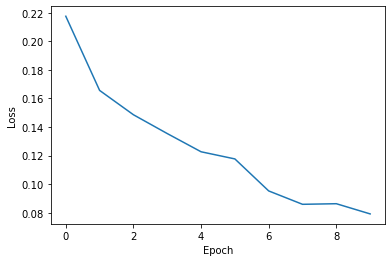

In [166]:
# learning first epochs with high rate 
EPOCHS_TO_TRAIN = 10
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

Epoch        0 Loss: 0.032281642659035936
Epoch        1 Loss: 0.02324457863069346
Epoch        2 Loss: 0.019771526937361256
Epoch        3 Loss: 0.017946073607245983
Epoch        4 Loss: 0.017135482338277972
Epoch        5 Loss: 0.016628925066712374
Epoch        6 Loss: 0.016225358245129003
Epoch        7 Loss: 0.015991417435991973
Epoch        8 Loss: 0.0157223806979552
Epoch        9 Loss: 0.015553802102147725


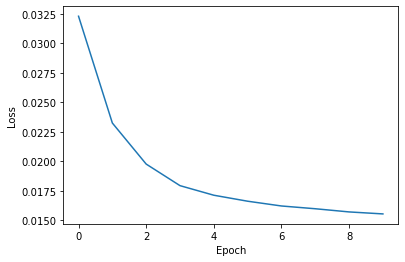

In [167]:
# continue learning with low rate
EPOCHS_TO_TRAIN = 10
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

Epoch        0 Loss: 0.012442305049574005
Epoch        1 Loss: 0.011822132291020363
Epoch        2 Loss: 0.011749691486102548
Epoch        3 Loss: 0.01169032378689401
Epoch        4 Loss: 0.011636129666501824
Epoch        5 Loss: 0.011578226455185452
Epoch        6 Loss: 0.011534243072205472
Epoch        7 Loss: 0.011484043880271577
Epoch        8 Loss: 0.011440576505550694
Epoch        9 Loss: 0.011400043980255486


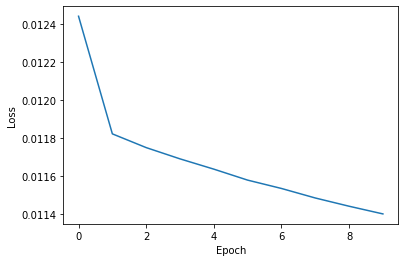

In [169]:
# finish learning with lower rate
EPOCHS_TO_TRAIN = 10
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.001))

## Test

Accuracy of the network on the 25000 test samples: 98.988


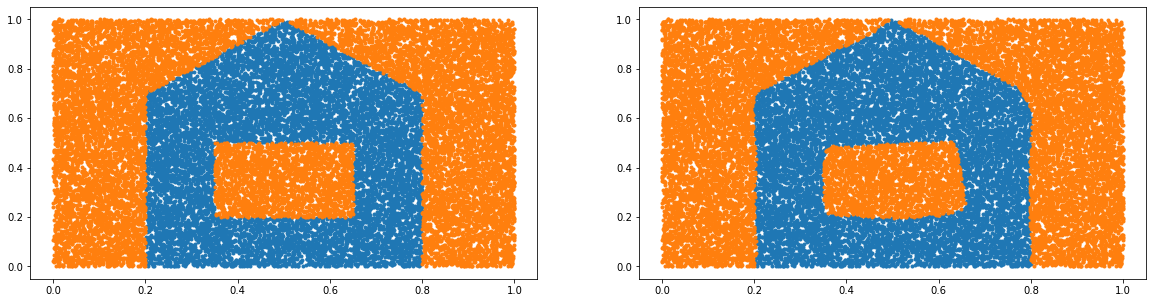

In [170]:
test_dataset = WindowedDomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Homework

- [ ] Обучить обычный домик (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл
- [ ] Обучить домик с многоклассовой классификацией (зa тавтологию извините) (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл
- [ ] Обучить домик с окошком (Accuracy >98%). 1 балл
- [ ] Использовать для этого трехслойную сеть. 1 балл
- [ ] Обучить домик с дверью и двумя окошками (Accuracy >98%). 2 балла
- [ ] Использовать для этого трехслойную сеть. 2 балла

#### ВАЖНО! ВЫБОРКУ УВЕЛИЧИВАТЬ НЕЛЬЗЯ!

Домашку выполняем в этой тетрадке и заливаем на гит, инструкция - https://youtu.be/lPcEQJiHDfg. Форма для сдачи - https://forms.gle/RJtnENVjGP6H5oPn6 \
Удачи!

## Domik with door and 2 windows dataset

In [171]:
class DoorDomikDataset(WindowedDomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _door(self, point, width=0.2, height=0.5, x=0.5):
        y = height / 2
        is_door = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_door
    
    def _window(self, point, width=0.1, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def show(self):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []
        door_x = []
        door_y = []

        for sample in self:
            point, target = sample
            if target == 1:
                domik_x.append(point[0])
                domik_y.append(point[1])
            elif target == 0: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])
            else:
                door_x.append(point[0])
                door_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.', door_x, door_y, '.')
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point, x=0.3):
                targets[i] = torch.tensor([0.], device=device)
            if self._window(point, x=0.7):
                targets[i] = torch.tensor([0.], device=device)
            if self._door(point):
                targets[i] = torch.tensor([2.], device=device)
                
            targets[i] = int(targets[i].item())
        return points, targets

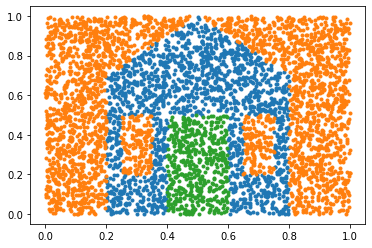

In [175]:
DATASET_SIZE = 5000
domik = DoorDomikDataset(DATASET_SIZE)
domik.show()

## Net

In [176]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=3, bias=True)
)


## Train

In [177]:
# learning first epochs with high rate 
EPOCHS_TO_TRAIN = 10
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

AttributeError: 'int' object has no attribute 'to'

## Test

In [ ]:
def test_door_domik(network, test_dataset):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []
    door_x = []
    door_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (output == target).sum().item()

            # dividing dataset for plotting
            if output == 1:
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            elif output == 2:
                door_x.append(inp[0])
                door_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.', door_x, door_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

In [ ]:
test_dataset = DoorDomikDataset(DATASET_SIZE*5)
test_door_domik(network=net, test_dataset=test_dataset)